In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/Othercomputers/My MacBook Air/thesis/model'
root = '/content/drive/Othercomputers/My MacBook Air/thesis'

Mounted at /content/drive


# imports

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr

import pymc as pm
import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
pm.__version__

'5.1.2'

In [ ]:
RANDOM_SEED = 5434
rng = np.random.default_rng(RANDOM_SEED)

az.style.use('arviz-darkgrid')

# data

In [ ]:
idata = az.from_netcdf('{}/clip2021_idata.nc'.format(path))
idata_zero = az.from_netcdf('{}/clip2021_idata_zero.nc'.format(path))

# example

array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

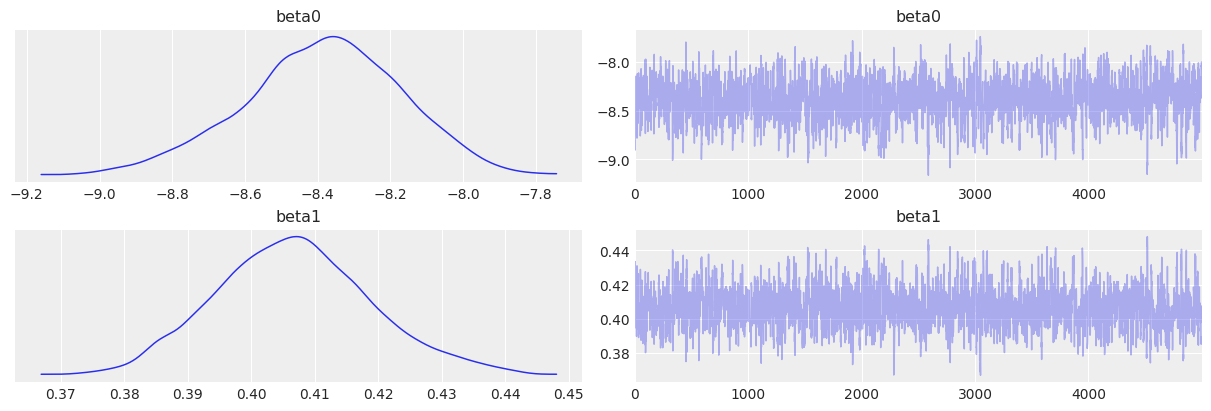

In [ ]:
az.plot_trace(idata)

array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'psi'}>, <Axes: title={'center': 'psi'}>]],
      dtype=object)

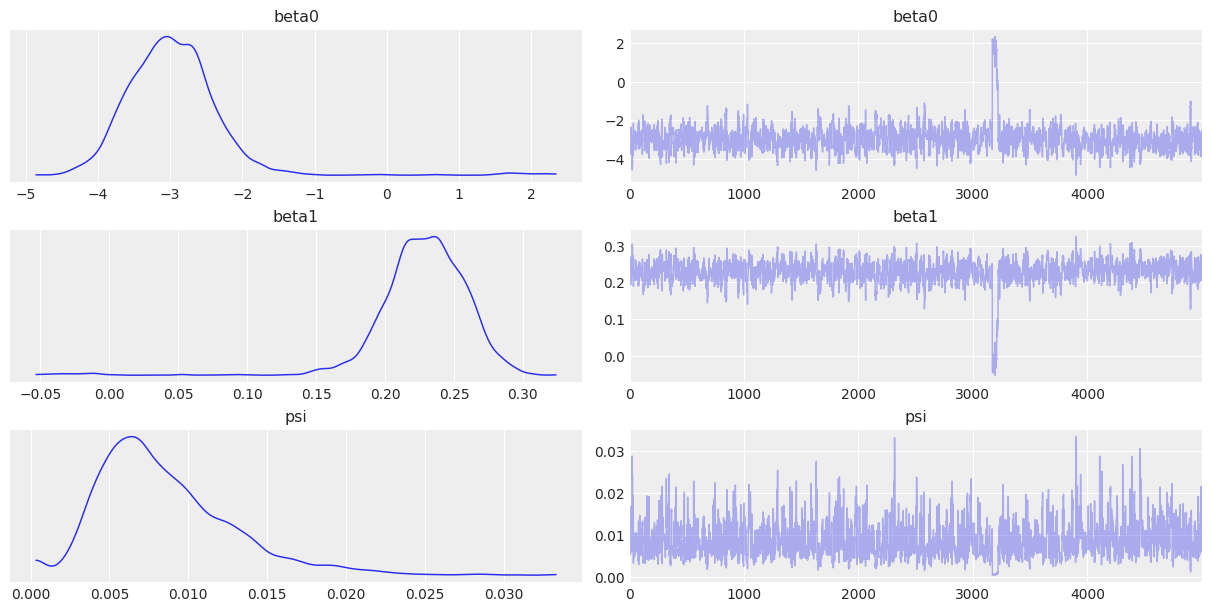

In [ ]:
az.plot_trace(idata_zero)

In [ ]:
ds = xr.load_dataset('{}/clip2021.nc'.format(path))
ds

<xarray.Dataset>
Dimensions:      (x: 51, y: 51, time: 31)
Coordinates:
  * x            (x) float64 95.0 95.1 95.2 95.3 95.4 ... 99.7 99.8 99.9 100.0
  * y            (y) float64 55.0 55.1 55.2 55.3 55.4 ... 59.7 59.8 59.9 60.0
  * time         (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
    spatial_ref  int32 0
Data variables:
    FWI          (time, y, x) float64 0.4043 0.4149 0.4229 ... 3.922 3.737 3.707
    counts       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.7

In [ ]:
X = ds.FWI.to_numpy().flatten()
y = ds.counts.to_numpy().flatten().astype('int')

df = pd.DataFrame({'X': X, 'y': y})
df.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df.X, df.y, 
                                                    train_size=.7, 
                                                    random_state=RANDOM_SEED)

In [ ]:
with pm.Model() as model:
    X = pm.MutableData('X', X_test)
    y = pm.MutableData('y', y_test)
    
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)

    mu = pm.math.exp(beta0 + beta1 * X)
    pm.Poisson('pred', mu=mu, observed=y)

In [ ]:
with model:
    posterior = pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED)

In [ ]:
with model:
    pm.compute_log_likelihood(idata)


In [ ]:
with pm.Model() as model_zero:
    X = pm.MutableData('X', X_test)
    y = pm.MutableData('y', y_test)
    
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    psi = pm.Beta('psi', alpha=1, beta=1)

    mu = pm.math.exp(beta0 + beta1 * X)
    pm.ZeroInflatedPoisson('pred_zero', psi=psi, mu=mu, observed=y)

In [ ]:
with model_zero:
    posterior_zero = pm.sample_posterior_predictive(idata_zero, random_seed=RANDOM_SEED)

In [ ]:
with model_zero:
    pm.compute_log_likelihood(idata_zero)

In [ ]:
az.waic(idata)

/usr/local/lib/python3.9/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 5000 posterior samples and 24190 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -97.02    35.03
p_waic        1.88        -

There has been a warning during the calculation. Please check the results.

In [ ]:
az.waic(idata_zero)

/usr/local/lib/python3.9/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 5000 posterior samples and 24190 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -68.50    26.00
p_waic        3.74        -

There has been a warning during the calculation. Please check the results.

In [ ]:
posterior.to_netcdf('{}/clip2021_posterior.nc'.format(path))
posterior_zero.to_netcdf('{}/clip2021_posterior_zero.nc'.format(path))

'/content/drive/Othercomputers/My MacBook Air/thesis/model/clip2021_posterior_zero.nc'

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=.99, top=1.01)
ax.set_xlim(right=1.5)
az.plot_ppc(posterior, ax=ax)
ax.set_yticks(np.linspace(.99, 1, 2))
ax.set_xticks(np.linspace(0, 1, 2))

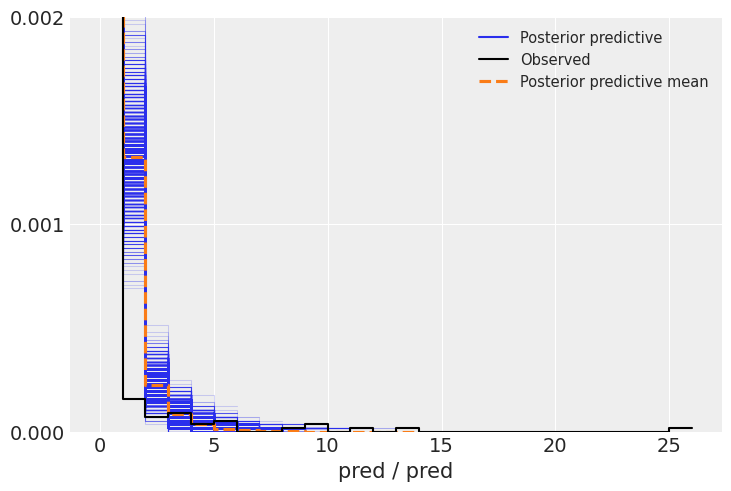

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim(top=.002)
az.plot_ppc(posterior, ax=ax)
ax.set_yticks(np.linspace(0, .002, 3))

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim(top=.002)
az.plot_ppc(posterior_zero, ax=ax)
ax.set_yticks(np.linspace(0, .002, 3))

In [ ]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-8.376,0.207,-8.754,-7.987,0.007,0.005,808.0,925.0,1.01
beta1,0.406,0.012,0.384,0.428,0.000,0.000,806.0,798.0,1.01


In [ ]:
beta0, beta1 = pm.summary(idata)['mean']
beta0_hdi3, beta1_hdi3 = pm.summary(idata)['hdi_3%']
beta0_hdi97, beta1_hdi97 = pm.summary(idata)['hdi_97%']

In [ ]:
pred = np.exp(beta0 + beta1 * X_test)
pred_hdi3 = np.exp(beta0_hdi3 + beta1_hdi3 * X_test)
pred_hdi97 = np.exp(beta0_hdi97 + beta1_hdi97 * X_test)

In [ ]:
pred

14621    0.000230
49113    0.000395
68114    0.000890
12675    0.000231
76668    0.000473
           ...   
64333    0.000270
24959    0.000234
37544    0.001792
77907    0.000289
6641     0.000269
Name: X, Length: 24190, dtype: float64

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7f3822e4f700> (for post_execute):


KeyboardInterrupt: ignored

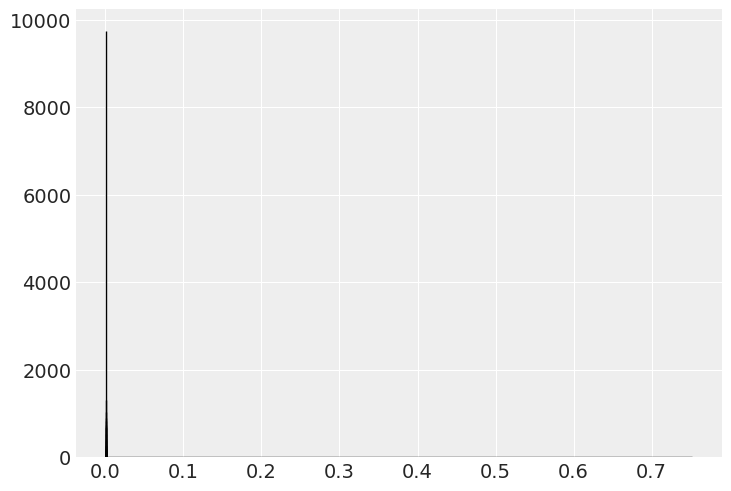

In [ ]:
sns.histplot(pred)